In [11]:
!pip install pymagnitude ekphrasis -q

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Specify Hyperparameters

In [0]:
BATCH_SIZE = 512
DROPOUT_PROBABILITY = 0.4
LEARNING_RATE = 1e-3
N_RNN_LAYERS = 1
PYTORCH_EMBEDDING_DIMENSION = 300
HIDDEN_SIZE = 128
IS_BIDIRECTIONAL = True

# Will be downloaded in the cell below
DATA_FILE = 'data/Train.csv'
MAPPING_FILE = 'data/Mapping.csv'

## Download the training data

In [13]:
!rm -r sample_data/

# Add your own Kaggle username and API key here!
!KAGGLE_USERNAME=suzile KAGGLE_KEY=81bcc8bcde4a1132ff8d338a5d4c8074 kaggle datasets download -d hariharasudhanas/twitter-emoji-prediction

!unzip twitter-emoji-prediction.zip -d data/
!rm twitter-emoji-prediction.zip

rm: cannot remove 'sample_data/': No such file or directory
twitter-emoji-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  twitter-emoji-prediction.zip
replace data/Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/Train.csv          
  inflating: data/Test.csv           
  inflating: data/OutputFormat.csv   
  inflating: data/Mapping.csv        
rm: cannot remove 'twitter-emoji-prediction.zip': No such file or directory


## Preprocess the text

In [14]:
tokenizer = TextPreProcessor(
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'url', 'date', 'number'],
    annotate={'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
    fix_html=True,    
    segmenter='twitter', 
    corrector='twitter', 
    unpack_hashtags=True,
    unpack_contractions=True,
    spell_correct_elong=False,
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons],
)

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [0]:
class TwitterEmojiDataset(Dataset):
    def __init__(self, data_filename, mapping_filename):
        df = pd.read_csv(data_filename, index_col=0).iloc[:1000]  # TODO: remove limit
        
        labels_df = pd.read_csv(mapping_filename, index_col=0)
        self.idx2emoji = dict(zip(
            labels_df.number.tolist(), 
            labels_df.emoticons.tolist(),
        ))
        self.emoji2idx = {emoji: idx for idx, emoji in self.idx2emoji.items()}
        
        df['tokenized_text'] = df.TEXT.progress_apply(tokenizer.pre_process_doc)
        
        vocab = sorted({
            sublst for lst in df.tokenized_text.tolist() for sublst in lst
        })
        
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        
        # Add a padding idx
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
        df['indexed_tokens'] = df.tokenized_text.apply(
            lambda tokens: [self.token2idx[token] for token in tokens],
        )
        self.text = df.TEXT.tolist()
        self.sequences = df.indexed_tokens.tolist()
        self.targets = df.Label.tolist()
        
        assert len(self.sequences) == len(self.targets)

    def __getitem__(self, i):
        return self.sequences[i], self.targets[i],  self.text[i]
    
    def __len__(self):
        return len(self.sequences)

In [16]:
dataset = TwitterEmojiDataset(DATA_FILE, MAPPING_FILE)
len(dataset.token2idx)

100%|██████████| 1000/1000 [00:01<00:00, 657.12it/s]


3655

## Split into training, validation, and test sets

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [0]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * test_ratio)
    valid_length = int(len(corpus) * valid_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

In [18]:
train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(900, 50, 50)

In [0]:
def collate(batch):
    inputs = [item[0] for item in batch]
    target = torch.LongTensor([item[1] for item in batch])
    text = [item[2] for item in batch]
    return inputs, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

In [0]:
def pad_sequences(sequences, padding_val=0, pad_left=False):
    """Pad a list of sequences to the same length with a padding_val."""
    sequence_length = max(len(sequence) for sequence in sequences)
    if not pad_left:
        return [
            sequence + (sequence_length - len(sequence)) * [padding_val]
            for sequence in sequences
        ]
    return [
        (sequence_length - len(sequence)) * [padding_val] + sequence
        for sequence in sequences
    ]

In [0]:
class RNNClassifier(nn.Module):
    """Classify a URL as class "primary" or class "secondary"."""
    def __init__(self, output_size, hidden_size, vocab_size, padding_idx,
                 device, dropout_probability=0.3, bidirectional=False, n_layers=1,
                 embedding_dimension=50, batch_size=32):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.n_layers = n_layers
        self.dropout_probability = dropout_probability
        self.device = device
        self.padding_idx = padding_idx
        
        # We need to multiply some layers by two if the model is bidirectional
        self.input_size_factor = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)
        
        self.rnn = nn.LSTM(
            embedding_dimension,
            self.hidden_size,
            self.n_layers,
            bidirectional=bidirectional,
        )
        self.fc = nn.Linear(
            self.hidden_size * self.input_size_factor,
            self.output_size,
        )

    def init_hidden(self):
        """Set initial hidden states."""
        h0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden_size,
        )
        c0 = torch.randn(
            self.n_layers * self.input_size_factor,
            self.batch_size,
            self.hidden_size,
        )
        
        h0 = h0.to(self.device)
        c0 = c0.to(self.device)

        return h0, c0

    def forward(self, inputs, return_activations=False):
        batch_size = len(inputs)
        
        # This makes the model not break for the last batch that might be less
        # than batch_size in size
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        lengths = torch.LongTensor([len(x) for x in inputs])
        lengths, permutation_indices = lengths.sort(0, descending=True)

        # Pad sequences so that they are all the same length
        padded_inputs = pad_sequences(inputs, padding_val=self.padding_idx)
        inputs = torch.LongTensor(padded_inputs)

        # Sort inputs
        inputs = inputs[permutation_indices].to(self.device)
        
        # Get embeddings
        embedding_out = self.embedding(inputs)
        
        packed = pack_padded_sequence(
            embedding_out,
            lengths,
            batch_first=True,
        )
        activations, _ = self.rnn(packed, self.init_hidden())
        activations, _ = pad_packed_sequence(activations, batch_first=True)
        
        indices = (lengths - 1).view(-1, 1).expand(
            activations.size(0), activations.size(2),
        ).unsqueeze(1)
        indices = indices.to(self.device)
        
        activations = activations.gather(1, indices).squeeze(1)
        out = torch.sigmoid(self.fc(activations))

        # Put the output back in correct order
        permutation_index_pairs = list(zip(
            permutation_indices.tolist(),
            list(range(len(permutation_indices))),
        ))
        reordered_indices = [
            pair[1] for pair
            in sorted(permutation_index_pairs, key=lambda pair: pair[0])
        ]

        if return_activations:
            return out[reordered_indices], self.fc(activations)[reordered_indices]

        return out[reordered_indices]

In [23]:
model = RNNClassifier(
    output_size=len(dataset.idx2emoji),
    hidden_size=HIDDEN_SIZE,
    embedding_dimension=PYTORCH_EMBEDDING_DIMENSION,
    vocab_size=len(dataset.token2idx),
    padding_idx=dataset.token2idx['<PAD>'],
    dropout_probability=DROPOUT_PROBABILITY,
    bidirectional=IS_BIDIRECTIONAL,
    n_layers=N_RNN_LAYERS,
    device=device,
    batch_size=BATCH_SIZE,
)
model = model.to(device)
model

RNNClassifier(
  (embedding): Embedding(3655, 300)
  (rnn): LSTM(300, 128, bidirectional=True)
  (fc): Linear(in_features=256, out_features=20, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
)
scheduler = CosineAnnealingLR(optimizer, 1)

In [0]:
def train_epoch(model, optimizer, scheduler, train_loader):
    model.train()
    total_loss = total = 0
    for inputs, target, text in tqdm_notebook(train_loader, desc='Training', leave=False):
        target = target.to(device)

        # Clean old gradients
        optimizer.zero_grad()

        # Forwards pass
        output = model(inputs)

        # Calculate how wrong the model is
        loss = criterion(output, target)

        # Perform gradient descent, backwards pass
        loss.backward()

        # Take a step in the right direction
        optimizer.step()
        scheduler.step()

        # Record metrics
        total_loss += loss.item()
        total += len(target)

    return total_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    total_loss = total = 0
    with torch.no_grad():
        for inputs, target, text in tqdm_notebook(valid_loader, desc='Validating', leave=False):
            target = target.to(device)

            # Forwards pass
            output = model(inputs)

            # Calculate how wrong the model is
            loss = criterion(output, target)

            # Record metrics
            total_loss += loss.item()
            total += len(target)

    return total_loss / total

In [26]:
n_epochs = 0
train_losses, valid_losses = [], []
while True:
    train_loss = train_epoch(model, optimizer, scheduler, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )
    
    # Early stopping if the current valid_loss is
    # greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 0.007	valid_loss: 0.059



epoch #  2	train_loss: 0.007	valid_loss: 0.059



epoch #  3	train_loss: 0.007	valid_loss: 0.059



epoch #  4	train_loss: 0.007	valid_loss: 0.059



epoch #  5	train_loss: 0.007	valid_loss: 0.059



epoch #  6	train_loss: 0.007	valid_loss: 0.059



epoch #  7	train_loss: 0.006	valid_loss: 0.059



epoch #  8	train_loss: 0.006	valid_loss: 0.059



epoch #  9	train_loss: 0.006	valid_loss: 0.059



epoch # 10	train_loss: 0.006	valid_loss: 0.058



epoch # 11	train_loss: 0.006	valid_loss: 0.058



epoch # 12	train_loss: 0.006	valid_loss: 0.058



epoch # 13	train_loss: 0.006	valid_loss: 0.058



epoch # 14	train_loss: 0.006	valid_loss: 0.058



epoch # 15	train_loss: 0.006	valid_loss: 0.058



epoch # 16	train_loss: 0.006	valid_loss: 0.058



epoch # 17	train_loss: 0.006	valid_loss: 0.058



epoch # 18	train_loss: 0.006	valid_loss: 0.057



epoch # 19	train_loss: 0.006	valid_loss: 0.057



epoch # 20	train_loss: 0.006	valid_loss: 0.057



epoch # 21	train_loss: 0.006	valid_loss: 0.057



epoch # 22	train_loss: 0.006	valid_loss: 0.057



epoch # 23	train_loss: 0.006	valid_loss: 0.057



epoch # 24	train_loss: 0.006	valid_loss: 0.057



epoch # 25	train_loss: 0.006	valid_loss: 0.057



epoch # 26	train_loss: 0.006	valid_loss: 0.057

Stopping early


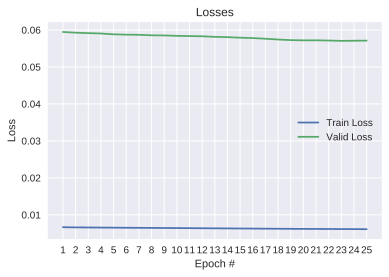

In [27]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

## Predictions

In [28]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

model.eval()
test_accuracy = n_examples = 0
with torch.no_grad():
    for inputs, target, text in test_loader:
        target = target.to(device)

        _, logits = model(inputs, return_activations=True)

        logits = logits.detach().cpu().numpy()
        target = target.cpu().numpy()
        
        test_accuracy += accuracy(logits, target)
        n_examples += len(target)
        
print(test_accuracy / n_examples)

0.24


In [0]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, target_lst, text_lst = map(flatten, [inputs_lst, target_lst, text_lst])
test_examples = list(zip(inputs_lst, target_lst, text_lst))

def print_random_prediction(n=10):
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, text = random.choice(test_examples)
            target = target.item()
            
            _, logits = model([inputs], return_activations=True)
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = dataset.idx2emoji[prediction]
            actual = dataset.idx2emoji[target]
            
            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>Tweet</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [30]:
print_random_prediction(n=30)